# Problem Statement

A client has a problem with employee attrition and they would like to know which employees are most likely to leave the company. The client wants to understand what is driving attrition and how to improve employee retention.

# Approach

In order to understand the factors responsible for attrition we framed a Data Science Model. Since we have the employment end date available with us, we will consider them as Attrition employees. The employees without an end date means they are still in the organisation. We created a binary response using this approach. Next, we have several features which can be processed and fed into the Classification Model

<u>Assumption</u> - Attrition reports does not include layoff figures. When we report attrition and other employee-turnover rates, layoffs are reported as a separate factor from attrition in the staffing numbers (Source - https://smallbusiness.chron.com/count-layoffs-attrition-37044.html)

We will follow the popular <b>CRISM DM</b> Methodolgy (CRoss-InduStry Process for Data Mining) for our problem.

- Business understanding
- Data understanding & Exploratory Data Analysis
- Data pre-processing
- Modeling & Evaluation
- Model Execution/Deployment

Based on the insights from EDA and Predictive Modeling, we can focus on creating strategies on how to prevent employees from leaving the company. It will be a collaboration of Data Scientists, HR, Management Team to understand the factors and meet with employees to better understand  work load and satisfaction and reducing attrition.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
import re
#%%capture
from fancyimpute import KNN
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,f1_score,recall_score,precision_score,plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Data Understanding

There are 3 data tables:

1.<b>Employee.csv</b> – information about each employee

2.<b>PerformanceReview.csv</b> – employees' yearly performance reviews

3.<b>Survey.csv</b> – employees' survey responses regarding satisfaction and work/life balance

In [2]:
employee_df = pd.read_excel('/Users/sagarsahoo/Downloads/case_study/employee.xlsx')
performance_df = pd.read_excel('/Users/sagarsahoo/Downloads/case_study/performance.xlsx')
survey_df = pd.read_excel('/Users/sagarsahoo/Downloads/case_study/survey.xlsx')

In [3]:
employee_df.head(3)

,EmployeeId,CommuteDistance,DegreeCompleted,DegreeField,Department,EmploymentEndDate,EmploymentEndReason,EmploymentStartDate,Gender,JobLevel,MaritalStatus,NumPreviousCompanies,NumYearsWorked,OvertimeDays,OvertimeHours,Salary,TrainingsAttended,TravelFrequency,WeeklyHoursBudgeted,YearOfBirth
0,1001,10,Master,Business,Accounting,NaT,NaN,2014-12-12,Female,4,Married,2.0,13,1,2,96800,0,None,40,1980
1,1002,7,Master,Other,Other,NaT,NaN,2017-10-10,Female,2,Single,2.0,12,1,5,60400,1,Monthly,40,1986
2,1003,9,Bachelor,Business,Other,2019-03-08,Retired,2014-07-23,Male,2,Married,NaN,5,4,15,49100,2,No travel,40,1992


We remove the "Fired" employees from the Model as we have assumed that such employees are not considered as Attrition employees

In [4]:
employee_df = employee_df[employee_df['EmploymentEndReason']!='Fired']

In [5]:
performance_df.head(3)

,EmployeeId,ReviewDate,PerformanceRating
0,1001,2015-12-14,3
1,1001,2016-12-13,3
2,1001,2017-12-13,3


In [6]:
survey_df.head(3)

,EmployeeId,QuestionNum,QuestionText,Response
0,1001,Q1,How satisfied are you with your job?,Very Satisfied
1,1001,Q2,How satisfied are you with the company?,Neither Satisfied nor Unsatisfied
2,1001,Q3,How satisfied are you with your manager?,Somewhat Satisfied


# Data Preprocessing

We are devising a model to predict the attritions at an employee level. In the performance sheet, we see that employees are given ratings on the basis of a performance review date.We need to aggregate the ratings at an employee level. There are various ways to do it, such as 
    - We take the count of each ratings such as create 5 Features - Count of 1 Ratings, Count of 2 Ratings i.e 
      for each of the rating level.
    - Average of the Ratings
    - Median of the Ratings
    - Create weighted ratings by focusing more on recent year ratings

Here, we have considered Average/Mean of the ratings the employee received across the years.

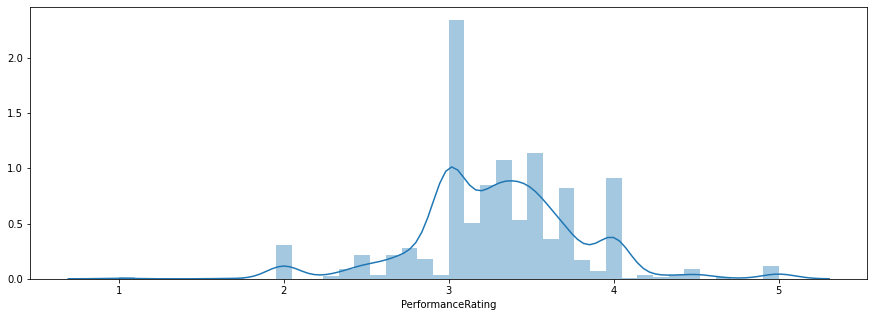

In [43]:
performance_agg_df = performance_df.groupby('EmployeeId').agg({'PerformanceRating':'mean'}).reset_index()
plt.figure(figsize=(15,5))
sns.distplot(performance_agg_df['PerformanceRating'])
plt.show()

With reference to the survey data, we see that there are 4 Specific Questions with 10 Response Types. Since the response ordering matters, we are representing the response using Scores with 10 as Excellent and Very Poor as 1. This way we are taking into account the  response ordering for each of the questions.

During analysis, it ws found that the EmployeeID Column in the Survery data source had a letter "e/E" at the begining of the EmployeeID which has been taken care of.

In [8]:
survey_df.replace(to_replace=['Excellent', 'Fair', 'Good', 'Neither Satisfied nor Unsatisfied', 'Poor', 'Somewhat Satisfied','Somewhat Unsatisfied', 'Very Poor', 'Very Satisfied', 'Very Unsatisfied'], value=[10,7,8,5,2,6,4,1,9,3],inplace=True)

survey_agg_df = survey_df.set_index(['EmployeeId','QuestionNum']).unstack()['Response'].reset_index()
survey_agg_df.columns=['EmployeeId','Q1','Q2','Q3','Q4']
survey_agg_df['EmployeeId'] = survey_agg_df['EmployeeId'].apply(str)
survey_agg_df['EmployeeId'] = survey_agg_df['EmployeeId'].apply(lambda row: re.sub("[^0-9]", "", row))
survey_agg_df['EmployeeId'] = survey_agg_df['EmployeeId'].apply(int)

Now, we have 3 Data Sources - Employee, Survey and Performance. We merge the three data sources now, so that we can proceed by taking into account all the features. We keep the index as EmployeeId in the merged dataframe.

In [9]:
intermediate_merge_df = pd.merge(employee_df,performance_agg_df,left_on='EmployeeId', right_on='EmployeeId',how='left')
employee_merged_df = pd.merge(intermediate_merge_df, survey_agg_df,left_on='EmployeeId', right_on='EmployeeId',how='left')
employee_merged_df.set_index('EmployeeId', inplace=True)
employee_final_df = employee_merged_df.copy()
employee_final_df.head(5)

,CommuteDistance,DegreeCompleted,DegreeField,Department,EmploymentEndDate,EmploymentEndReason,EmploymentStartDate,Gender,JobLevel,MaritalStatus,...,Salary,TrainingsAttended,TravelFrequency,WeeklyHoursBudgeted,YearOfBirth,PerformanceRating,Q1,Q2,Q3,Q4
EmployeeId,,,,,,,,,,,,,,,,,,,,,
1001,10,Master,Business,Accounting,NaT,NaN,2014-12-12,Female,4,Married,...,96800,0,None,40,1980,3.0,9,5,6,10
1002,7,Master,Other,Other,NaT,NaN,2017-10-10,Female,2,Single,...,60400,1,Monthly,40,1986,3.5,9,6,9,10
1003,9,Bachelor,Business,Other,2019-03-08,Retired,2014-07-23,Male,2,Married,...,49100,2,No travel,40,1992,3.0,5,6,6,8
1004,8,Master,Other,Marketing,NaT,NaN,2014-05-08,Male,2,Single,...,47100,0,No travel,40,1979,3.6,5,5,5,2
1005,7,Master,Computer Science,Marketing,NaT,NaN,2013-12-24,Male,4,Single,...,58700,1,Monthly,40,1979,3.0,9,5,6,7


In order to frame an Employee Attrition Model using Supervised Learning, we need to consider a response/label. Here we can use Emploee End Date to create a response. If an employee has the End Date populated, we can consider the employee has left the organization and if the Employement End Date is not available, we can consider that the employee is still with the company.

We create the Response variable "Attrition" and we drop the variables EmploymentEndDate and EmploymentEndReason from the merged data source.

In [10]:
#employee_df['Attrition'] = employee_df
employee_final_df.loc[employee_final_df['EmploymentEndDate'].isna(), 'Attrition'] = 0
employee_final_df.loc[employee_final_df['EmploymentEndDate'].notna(), 'Attrition'] = 1
employee_final_df.drop(columns=['EmploymentEndDate','EmploymentEndReason'],inplace=True)

The data source has YearofBirth and Employment Start Date. Both these features cannot be directly used into the Supervised Model, so if we calculate the Age and Years of Service in Current Company, we can use them as continuous features in the model.

In [11]:
employee_final_df['age']=pd.to_datetime('now').year - employee_final_df['YearOfBirth']
employee_final_df['Years_of_Service_Till_Now']=round((((pd.to_datetime('now') - employee_final_df['EmploymentStartDate'])/np.timedelta64(1, 'M')))/12,1)
employee_final_df.drop(columns=['EmploymentStartDate'],inplace=True)

Now we have made sure that the features in our model has either categorical or continuous. And we have a response variable in place as well.

Next, we proceed with <b>Missing Value Imputation</b> in the data source.

In [12]:
#Checing for Null Values in employee_final_df (Employee Master Data)
missing_employee_df = employee_final_df.isnull().sum().reset_index()
missing_employee_df.columns=['Feature','NoofMissing']
missing_employee_df[missing_employee_df['NoofMissing']>0]

,Feature,NoofMissing
2,DegreeField,21
6,MaritalStatus,67
7,NumPreviousCompanies,186
16,PerformanceRating,312


So, we see there are 4 Features which has missing values in it. So we start analysing them one by one

<u><b>Degree Field Imputation</b></u>

In [13]:
employee_final_df[employee_final_df['DegreeField'].isna()].DegreeCompleted.value_counts()

Below College    21
Name: DegreeCompleted, dtype: int64

We see that the DegreeField is missing for employees for whom the Degree Completed is Below College. So we wont say it as missing rather we can say it as Not Applicable. So we create a new category for such employees i.e <b>No Degree</b> for the DegreeField.

In [14]:
employee_final_df.loc[employee_final_df['DegreeCompleted']=='Below College', 'DegreeField'] = 'No Degree'

<u><b>Marital Status Imputation</b></u>

We try out to see if we can use Age/Gender to impute the Marital Status. But it doesnt look clear from the below box plot as the median value is almost same across the Gender and Marital Status

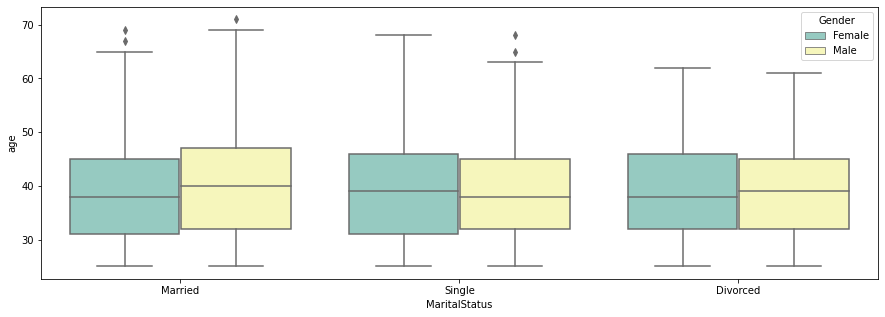

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
ax = sns.boxplot(x="MaritalStatus",y="age",hue="Gender",data=employee_final_df, palette="Set3")

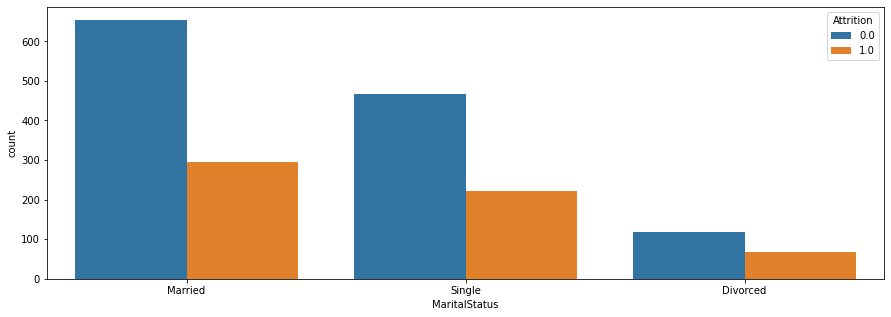

In [16]:
plt.figure(figsize=(15,5))
sns.countplot(employee_final_df['MaritalStatus'],hue=employee_final_df['Attrition'])

There is no significant difference in pattern if we see the count of employees under various Marital Status

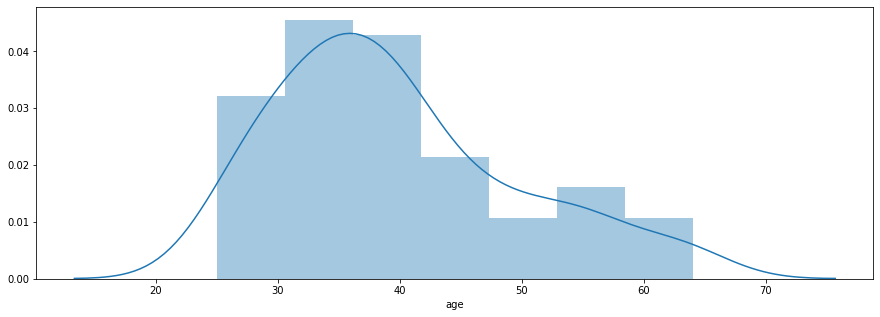

In [17]:
plt.figure(figsize=(15,5))
sns.distplot(employee_final_df[employee_final_df['MaritalStatus'].isnull()]['age'])

So, we see that is no significant pattern which can be used to impute the MaritalStatus. Hence, we now impute it with the Most frequent (Mode) class - Married

In [18]:
employee_final_df.loc[employee_final_df['MaritalStatus'].isna(), 'MaritalStatus'] = 'Married'

<u><b>Number of Previous Companies Imputation</b></u>

Since NumPreviousCompanies is a continuous feature, we can use relevant features - Job Level, Number of Years Worked, Age and Salary from the dataset and use KNN to predict the same.

In [19]:
warnings.filterwarnings('ignore')
missing_NumPreviousCompanies = KNN(k=3).fit_transform(employee_final_df[['JobLevel','NumYearsWorked','age','Salary','NumPreviousCompanies']])
employee_final_df['NumPreviousCompanies'] = missing_NumPreviousCompanies[:,-1].round()

Imputing row 1/1890 with 0 missing, elapsed time: 0.535
Imputing row 101/1890 with 0 missing, elapsed time: 0.537
Imputing row 201/1890 with 0 missing, elapsed time: 0.538
Imputing row 301/1890 with 0 missing, elapsed time: 0.539
Imputing row 401/1890 with 0 missing, elapsed time: 0.540
Imputing row 501/1890 with 0 missing, elapsed time: 0.541
Imputing row 601/1890 with 0 missing, elapsed time: 0.542
Imputing row 701/1890 with 0 missing, elapsed time: 0.543
Imputing row 801/1890 with 0 missing, elapsed time: 0.544
Imputing row 901/1890 with 0 missing, elapsed time: 0.545
Imputing row 1001/1890 with 0 missing, elapsed time: 0.546
Imputing row 1101/1890 with 0 missing, elapsed time: 0.548
Imputing row 1201/1890 with 0 missing, elapsed time: 0.549
Imputing row 1301/1890 with 0 missing, elapsed time: 0.550
Imputing row 1401/1890 with 0 missing, elapsed time: 0.551
Imputing row 1501/1890 with 0 missing, elapsed time: 0.552
Imputing row 1601/1890 with 0 missing, elapsed time: 0.553
Imputing 

<u><b>Performance Rating Imputation</b></u>

We saw previously that, the performance evaluation is missing for around 369 employees. We check the distribution of the Years these emploees have served in the current organization

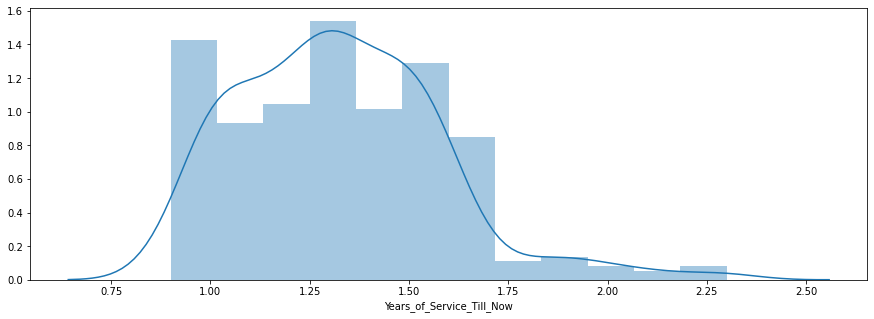

In [20]:
plt.figure(figsize=(15,5))
sns.distplot(employee_final_df[employee_final_df['PerformanceRating'].isna()]['Years_of_Service_Till_Now'])

We see that almost majority of these employees have served less than 2 Years. There could be a reason that they would have not been present in the performance cycle. So the ideal scenario would be to impute it with the default rating which is 3 across organizations.

In [21]:
employee_final_df.loc[employee_final_df['PerformanceRating'].isna(), 'PerformanceRating'] = 3

So, now we have <b>imputed all our missing values</b> in the merged data source.The same is validated below. We will next proceed to Exploratory Data Analysis

In [22]:
#Checing for Null Values in employee_df (Employee Master Data)
missing_employee_df = employee_final_df.isnull().sum().reset_index()
missing_employee_df[missing_employee_df[0]>0]

,index,0


In [23]:
employee_final_df.head(3)

,CommuteDistance,DegreeCompleted,DegreeField,Department,Gender,JobLevel,MaritalStatus,NumPreviousCompanies,NumYearsWorked,OvertimeDays,...,WeeklyHoursBudgeted,YearOfBirth,PerformanceRating,Q1,Q2,Q3,Q4,Attrition,age,Years_of_Service_Till_Now
EmployeeId,,,,,,,,,,,,,,,,,,,,,
1001,10,Master,Business,Accounting,Female,4,Married,2.0,13,1,...,40,1980,3.0,9,5,6,10,0.0,40,5.7
1002,7,Master,Other,Other,Female,2,Single,2.0,12,1,...,40,1986,3.5,9,6,9,10,0.0,34,2.8
1003,9,Bachelor,Business,Other,Male,2,Married,0.0,5,4,...,40,1992,3.0,5,6,6,8,1.0,28,6.1


# Exploratory Data Analysis

In [24]:
employee_processed_df = employee_final_df.copy()

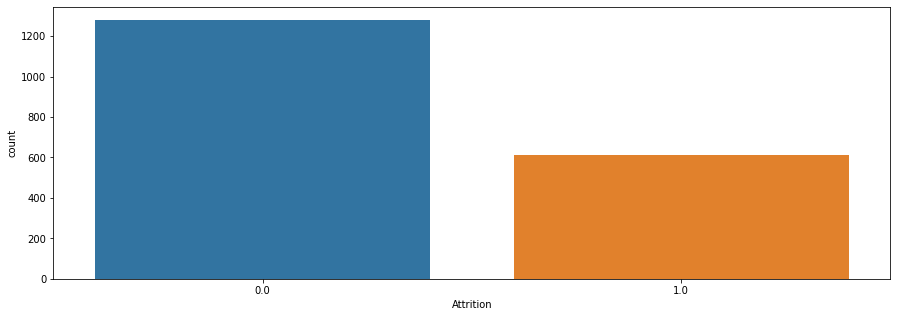

In [25]:
plt.subplots(figsize=(15,5))
sns.countplot(x='Attrition', data = employee_processed_df)

In [26]:
print("Attrition in the Employee Data Source: ", round(100*employee_processed_df.Attrition.mean()),'%')

Attrition in the Employee Data Source:  32.0 %


We can conclude that there is not too much of class imbalance. Hence we wont be going with Oversampling, Undersampling or SMOTE Techniques

Now, in order to understand the distribution of the continuos features, we plot the distributions using distplot of seaborn. 

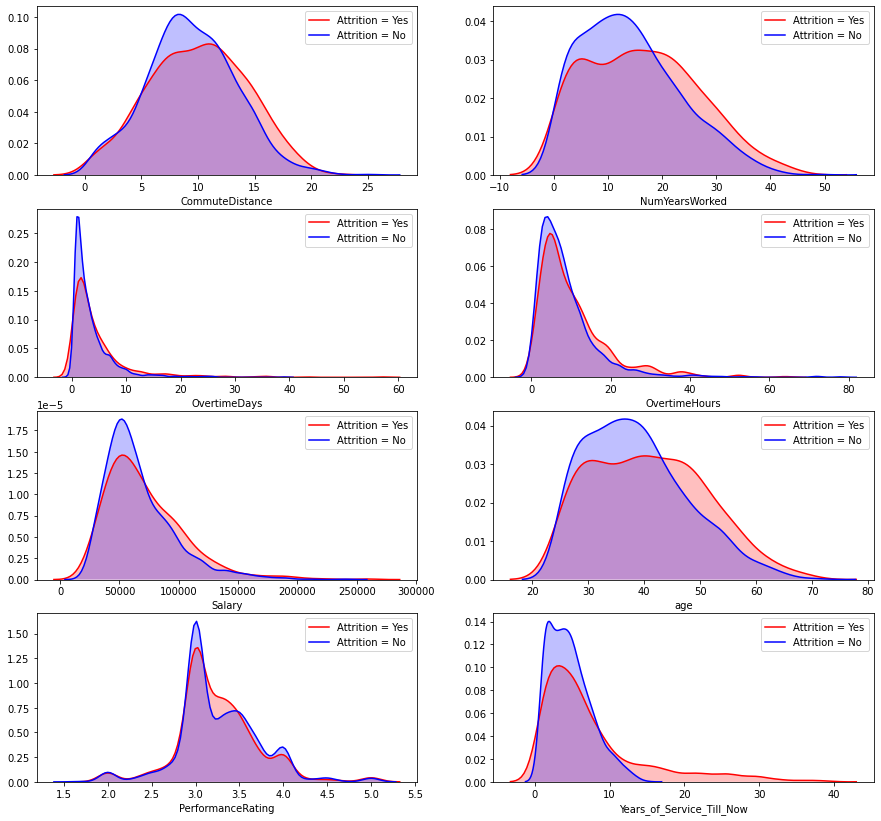

In [27]:
columns = ['CommuteDistance','NumYearsWorked','OvertimeDays','OvertimeHours','Salary','age','PerformanceRating','Years_of_Service_Till_Now']
plt.figure(figsize=(15,8))
j=0
for i in columns:
    j +=1
    plt.subplot(7,2,j)
    #sns.distplot(employee_processed_df[i])
    #sns.barplot(x = 'Attrition', y = employee_processed_df[i], data =employee_processed_df)
    sns.kdeplot(employee_processed_df[employee_processed_df['Attrition']==1][i],label='Attrition = Yes',shade='True',color='r')
    sns.kdeplot(employee_processed_df[employee_processed_df['Attrition']==0][i],label='Attrition = No',shade='True',color='b')
    plt.xlabel(i)
    
# Custom the subplot layout
plt.subplots_adjust(bottom=-0.9, top=1.5)
plt.show()
plt.close()

We could see that CommuteDistance, NumYearsWorked,PerformanceRating and age are closely normal whereas there is skewness in Salary, OvertimeDays and Overtime Hours. These right skewness can be reduced if we transform the values or remove the outliers. Since we donot want to lose the interpretation, we are keeping the values intact. 



- Attrition is more in employees with age > 45
- Performance Rating has some outliers, with very less employees on the maximum and minimum ratings. Employees with ratings in between 3-3.5 tend to leave the organisation more as compared to others
- With Salaries > ~75000, the attrition is more against employees with salaries less than ~75000
- Employees with more than  20 Years of experience tend to leave more as compared to others
- Employees who commute more than 12 Miles have shown higher attrition rates.

Now, for the ordinal/discrete features, we take the count plot against the Attrition variable.

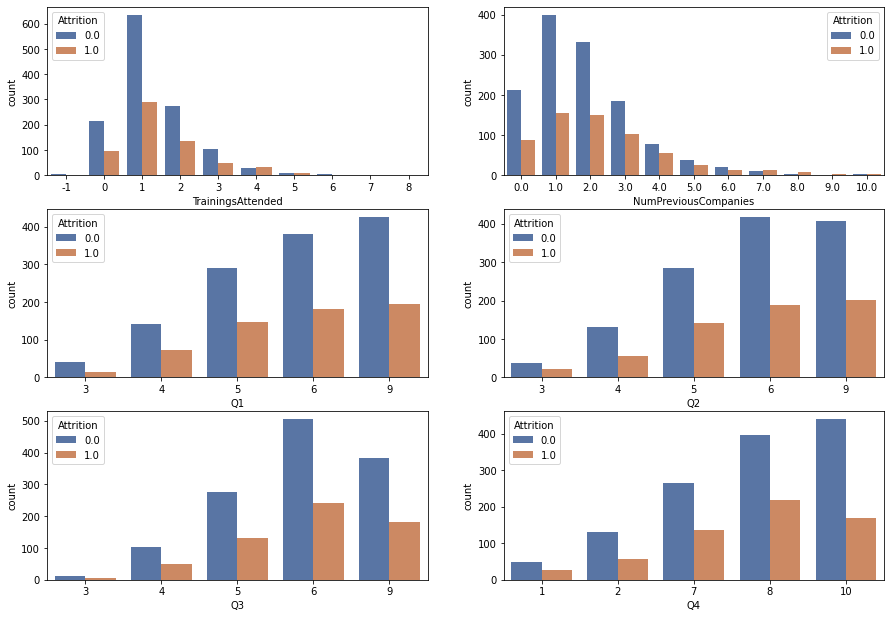

In [28]:
columns = ['TrainingsAttended','NumPreviousCompanies','Q1','Q2','Q3','Q4']
plt.figure(figsize=(15,8))
j=0
for i in columns:
    j +=1
    plt.subplot(7,2,j)
    #sns.barplot(employee_processed_df[i],hue=employee_processed_df['Attrition'])
    sns.countplot(i, data =employee_processed_df,hue='Attrition',palette="deep")
    
# Custom the subplot layout
plt.subplots_adjust(bottom=-0.9, top=1.5)
plt.show()
plt.close()

From the above countplots, we could observe that:
- Higher number of employees have left the company who have attended 1-2 Trainings and have worked for 2-3 companies previously
- Employees who have responded  "How satisfied are you with your manager?" with "Somewhat Satisfied" have higher chances of leaving the company
- Employees who responded to "How would you rate you work/life balance?" as Excellent showed lesser chance of leave the company

For the categorical features such as Degree, Gender, Marital Status, Department, we take the count plot and check if there is any trend/pattern of attrition

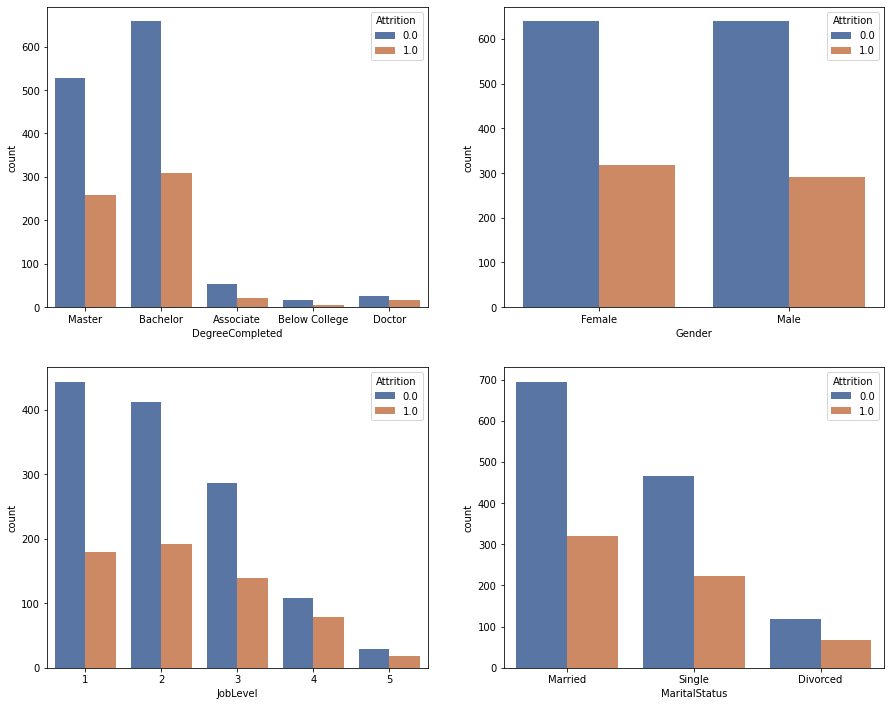

In [29]:
columns = ['DegreeCompleted','Gender','JobLevel','MaritalStatus']
plt.figure(figsize=(15,8))
j=0
for i in columns:
    j +=1
    plt.subplot(4,2,j)
    #sns.barplot(employee_processed_df[i],hue=employee_processed_df['Attrition'])
    sns.countplot(x=i, data=employee_processed_df,hue='Attrition',palette="deep")
    
    
# Custom the subplot layout
plt.subplots_adjust(bottom=-0.9, top=1.5)
plt.show()
plt.close()

From the above plots, we could see that 
- Employees with Masters and Bachelors degrees tend to leave more against other degrees
- Gender doesnt seem have an impact on the attrition. 
- Employees in Job Levels 1,2 and 3 leave quite often relative to Levels 4 and 5
- Married Employees have higher risk of attrition as compared to Single/Divorced Employees

There was <b>no significant pattern</b> identified for <b>Degree Field, Travel Frequency, Department </b>which differs for Attrition and Existing Employees

<u>Correlation Analysis</u>

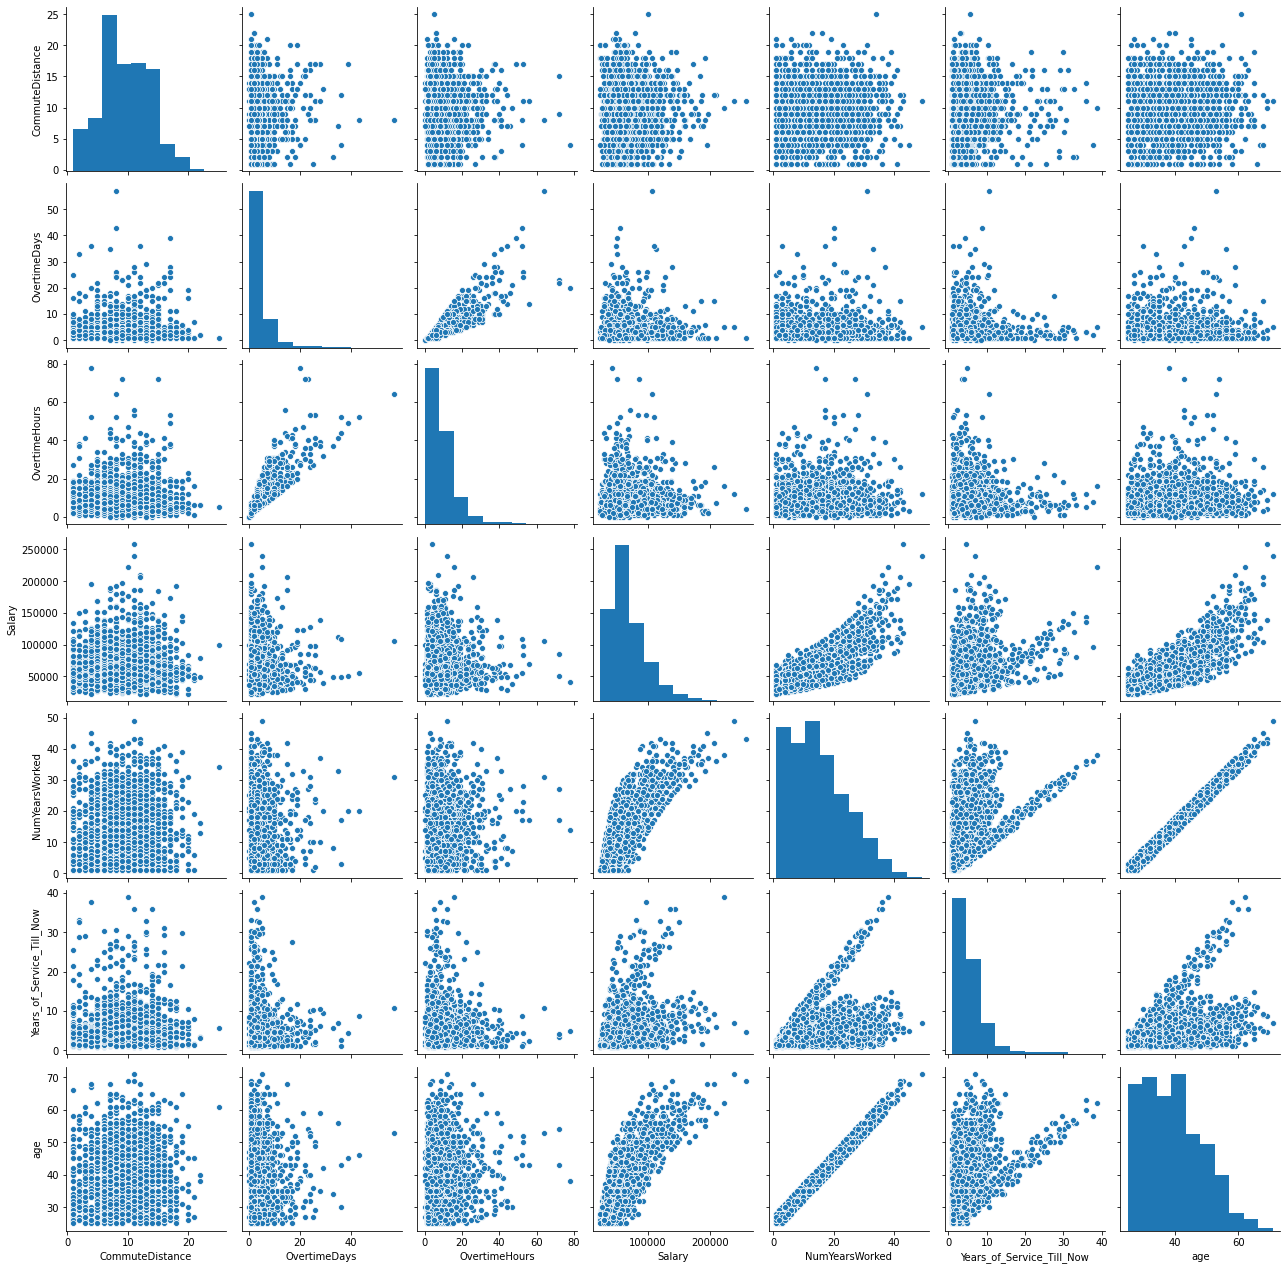

In [30]:
sns.pairplot(employee_processed_df[['CommuteDistance','OvertimeDays', 'OvertimeHours', 'Salary','NumYearsWorked',
       'Years_of_Service_Till_Now', 'age']])

From the above pair plots, we observe that:
- There exists a pattern between OverTime Hours and OverTime Days
- Number of Years Worked and Salary shows a strong relationship
- Number of Years worked is linearly co-related with age
- Age shows co-relation with Salary and Years of Service Till Now

This aligns as well with the below correlation values.

In [35]:
employee_processed_df[['CommuteDistance','OvertimeDays', 'OvertimeHours', 'Salary','NumYearsWorked',
       'Years_of_Service_Till_Now', 'age']].corr()

,CommuteDistance,OvertimeDays,OvertimeHours,Salary,NumYearsWorked,Years_of_Service_Till_Now,age
CommuteDistance,1.000000,-0.003470,-0.015113,0.015053,0.031371,0.013281,0.033664
OvertimeDays,-0.003470,1.000000,0.838595,0.019597,0.017351,-0.009452,0.021634
OvertimeHours,-0.015113,0.838595,1.000000,0.034431,0.042763,-0.009481,0.047048
Salary,0.015053,0.019597,0.034431,1.000000,0.789766,0.294651,0.779987
NumYearsWorked,0.031371,0.017351,0.042763,0.789766,1.000000,0.392171,0.984269
Years_of_Service_Till_Now,0.013281,-0.009452,-0.009481,0.294651,0.392171,1.000000,0.388112
age,0.033664,0.021634,0.047048,0.779987,0.984269,0.388112,1.000000


# Model Building and Evaluation

We will now start with Model Building. This includes removing redundant/insignificant features from the model and evaluating Logistic Regression, Decison Trees, Random Forest and Gradient Boosting Algorithms.

In order to evaluate the Model, we will use Grid Search to run each algorithm across a various range of hyper-paramters and use Recall Scoring as the metric to choose the model. The reason behind going Reecall Scoring is because it gives importance to False Negatives. We thereby choose the final model and then extract the top important features from the model. We will save the final model into a Pickel File and use it for future test run.

WeeklyHoursBudgeted is constant i.e 40 across all the employees. Since there is no difference against Attrition and Non-Attrition employees, we can ignore the feature from the Model.

Since overtime hours and days are co-related and the average variation of Overtime Days isnt too much of a difference, we exclude the same from the model.

In [36]:
X = employee_processed_df[['CommuteDistance', 'DegreeCompleted', 'DegreeField', 'Department',
       'Gender', 'JobLevel', 'MaritalStatus', 'NumPreviousCompanies',
       'NumYearsWorked', 'OvertimeHours', 'Salary','TrainingsAttended', 'TravelFrequency',
       'PerformanceRating', 'Q1', 'Q2', 'Q3', 'Q4','Years_of_Service_Till_Now','age']]

y = employee_processed_df[['Attrition']]

In [37]:
X = pd.get_dummies(data=X, columns=['DegreeCompleted', 'MaritalStatus','DegreeField', 'Department','Gender','TravelFrequency', 'MaritalStatus'])

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

<b>Dummy/Random Classifier</b>

In [39]:
strategies = ['stratified'] 
  
test_scores = [] 
for s in strategies: 
    dclf = DummyClassifier(strategy = s, random_state = 0) 
    dclf.fit(X_train, y_train) 
    score = dclf.score(X_train, y_train) 
    test_scores.append(score) 
    
print('Stratified Dummy Classifier Accuracy Score: ' , round(test_scores[0]*100,2),'%')

Stratified Dummy Classifier Accuracy Score:  55.36 %


<b><u> Logistic Regression</u></b> 

In [46]:
param_grid = {'C': np.arange(1e-05, 3, 0.1)}

#scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(),param_grid=param_grid, scoring='recall')

gs.fit(X_train, y_train)
#results = gs.cv_results_

print('################ Logistic Regression Results#######################')
print(gs.best_estimator_)
y_lr_gcv_train_pred = gs.best_estimator_.predict(X_train)
print('Training Accuracy-----',accuracy_score(y_train, y_lr_gcv_train_pred))
print('Training F1 Score-----',f1_score(y_train, y_lr_gcv_train_pred))
print('Training Precision Score-----',precision_score(y_train, y_lr_gcv_train_pred))
print('Training Recall Score-----',recall_score(y_train, y_lr_gcv_train_pred))




y_lr_gcv_test_pred = gs.best_estimator_.predict(X_test)
print('Testing Accuracy-----',accuracy_score(y_test, y_lr_gcv_test_pred))
print('Testing F1 Score-----',f1_score(y_test, y_lr_gcv_test_pred))
print('Testing Precision Score-----',precision_score(y_test, y_lr_gcv_test_pred))
print('Testing Recall Score-----',recall_score(y_test, y_lr_gcv_test_pred))


print('Confusion Matrix : \n', confusion_matrix(y_test, y_lr_gcv_test_pred))

################ Logistic Regression Results#######################
LogisticRegression(C=2.50001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Training Accuracy----- 0.718915343915344
Training F1 Score----- 0.3221690590111643
Training Precision Score----- 0.7266187050359713
Training Recall Score----- 0.2069672131147541
Testing Accuracy----- 0.7301587301587301
Testing F1 Score----- 0.34615384615384615
Testing Precision Score----- 0.7941176470588235
Testing Recall Score----- 0.22131147540983606
Confusion Matrix : 
 [[249   7]
 [ 95  27]]


<b><u> Decision Trees</u></b>

In [1229]:
%matplotlib inline

dt_gcv = DecisionTreeClassifier(random_state=0)

# Define the parameter values that should be searched

param_grid = {'criterion':('gini', 'entropy'), 'max_depth':[6,8,12,15],
              'min_samples_split':list(range(10, 100,10))}

# instantiate the grid
grid_dtc = GridSearchCV(dt_gcv, param_grid, scoring='recall')

# fit the grid with data
grid_dtc.fit(X_train,y_train)


# Actual model object fit with those best parameters
# Shows default parameters that we did not specify

print('################ Decision Trees Classification Results###############')
print(grid_dtc.best_estimator_)
y_dtc_gcv_train_pred = grid_dtc.best_estimator_.predict(X_train)
print('Training Accuracy-----',accuracy_score(y_train, y_dtc_gcv_train_pred))
print('Training F1 Score-----',f1_score(y_train, y_dtc_gcv_train_pred))
print('Training Precision Score-----',precision_score(y_train, y_dtc_gcv_train_pred))
print('Training Recall Score-----',recall_score(y_train, y_dtc_gcv_train_pred))

y_dtc_gcv_test_pred = grid_dtc.best_estimator_.predict(X_test)
print('Testing Accuracy-----',accuracy_score(y_test, y_dtc_gcv_test_pred))
print('Testing F1 Score-----',f1_score(y_test, y_dtc_gcv_test_pred))
print('Testing Precision Score-----',precision_score(y_test, y_dtc_gcv_test_pred))
print('Testing Recall Score-----',recall_score(y_test, y_dtc_gcv_test_pred))
print('Testing Confusion Matrix : \n', confusion_matrix(y_test, y_dtc_gcv_test_pred))

################ Decision Trees Classification Results###############
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
Training Accuracy----- 0.8994708994708994
Training F1 Score----- 0.8372591006423983
Training Precision Score----- 0.8766816143497758
Training Recall Score----- 0.8012295081967213
Testing Accuracy----- 0.6587301587301587
Testing F1 Score----- 0.473469387755102
Testing Precision Score----- 0.4715447154471545
Testing Recall Score----- 0.47540983606557374
Testing Confusion Matrix : 
 [[191  65]
 [ 64  58]]


<b><u>Random Forest Classifier</u></b>

In [1230]:
%matplotlib inline

rf_gcv = RandomForestClassifier(random_state=0)

# Define the parameter values that should be searched

param_grid = {'criterion':('gini', 'entropy'), 'max_depth':[6,8,12],'n_estimators': [10,20],
              'min_samples_split':list(range(20, 100,10))}

# instantiate the grid
grid_rfc = GridSearchCV(rf_gcv, param_grid, scoring='recall')

# fit the grid with data
grid_rfc.fit(X_train,y_train)


# Actual model object fit with those best parameters
# Shows default parameters that we did not specify

print('################ Random Forests Classification Results###############')
print(grid_rfc.best_estimator_)
y_rfc_gcv_train_pred = grid_rfc.best_estimator_.predict(X_train)
print('Training Accuracy-----',accuracy_score(y_train, y_rfc_gcv_train_pred))
print('Training F1 Score-----',f1_score(y_train, y_rfc_gcv_train_pred))
print('Training Precision Score-----',precision_score(y_train, y_rfc_gcv_train_pred))
print('Training Recall Score-----',recall_score(y_train, y_rfc_gcv_train_pred))


y_rfc_gcv_test_pred = grid_rfc.best_estimator_.predict(X_test)
print('Testing Accuracy-----',accuracy_score(y_test, y_rfc_gcv_test_pred))
print('Testing F1 Score-----',f1_score(y_test, y_rfc_gcv_test_pred))
print('Testing Precision Score-----',precision_score(y_test, y_rfc_gcv_test_pred))
print('Testing Recall Score-----',recall_score(y_test, y_rfc_gcv_test_pred))
print('Testing Confusion Matrix : \n', confusion_matrix(y_test, y_rfc_gcv_test_pred))

################ Random Forests Classification Results###############
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Training Accuracy----- 0.8029100529100529
Training F1 Score----- 0.5754985754985755
Training Precision Score----- 0.9439252336448598
Training Recall Score----- 0.4139344262295082
Testing Accuracy----- 0.7328042328042328
Testing F1 Score----- 0.3647798742138365
Testing Precision Score----- 0.7837837837837838
Testing Recall Score----- 0.23770491803278687
Testing Confusion Matrix : 
 [[24

<b><u>Gradient Boosting Classifier</u></b>

In [1237]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [30,40,50,100],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 6,8,10],
              'min_samples_leaf': [100,150] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, scoring="recall", n_jobs= 2, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

y_gbc_pred=gsGBC.predict(X_test)

#print('GridSearch Gradient Boosting Accuracy Score : ' ,accuracy_score(y_test, y_gbc_pred))
gb_pred_proba = gsGBC.predict_proba(X_test)
#print ('GridSearch Gradient Boosting AUC: ',roc_auc_score(y_test, gb_pred_proba[:,1]))

print('################ Gradient Boosting Classification Results###############')
print(GBC_best)
y_gbc_gcv_train_pred = GBC_best.predict(X_train)
print('Training Accuracy-----',accuracy_score(y_train, y_gbc_gcv_train_pred))
print('Training F1 Score-----',f1_score(y_train, y_gbc_gcv_train_pred))
print('Training Precision Score-----',precision_score(y_train, y_gbc_gcv_train_pred))

y_gbc_gcv_test_pred = GBC_best.predict(X_test)
print('Testing Accuracy-----',accuracy_score(y_test, y_gbc_gcv_test_pred))
print('Testing F1 Score-----',f1_score(y_test, y_gbc_gcv_test_pred))
print('Testing Precision Score-----',precision_score(y_test, y_gbc_gcv_test_pred))
print('Testing Confusion Matrix : \n', confusion_matrix(y_test, y_gbc_gcv_test_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   30.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 480 out of 480 | elapsed:  1.1min finished


################ Gradient Boosting Classification Results###############
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Training Accuracy----- 0.8227513227513228
Training F1 Score----- 0.6492146596858639
Training Precision Score----- 0.8985507246376812
Testing Accuracy----- 0.6931216931216931
Testing F1 Score----- 0.3695652173913043
Testing Prec

From the above models, we see that for <b>Random Forests</b> we achieved a Training Accuracy of 80% and Testing Accuracy of 73%. The base/random classifier gave an accuracy of 55%. So there is a 18% improvement because of the Machine Learning Model for the Test Data. 

The Random Forests Model had an accuracy of 80% with 0.40 Recall for the Training Dataset. If we create a custom cost matrix wherein we penalize the False Negatives, we can improve the predictions.

<u>Cross Validation</u>

Initially, we have split our entire data into training and test data and used train_test_split with a fix random state. In order to evaluate our model, we now use <b>Cross Validation</b> and see how the model perform on various splits. It will helps us know how would the model performs on various splits.

We will run it on the entire dataset rather than on the Training Data i.e X, y and check the average accuracy over the 5 Folds. We are using Stratified Sampling such that the class ratio is also maintained during the split.

In [1134]:
skfold = StratifiedKFold(n_splits=5, random_state=0)
results_skfold = cross_val_score(grid_rfc.best_estimator_, X, y, cv=skfold)
print("Accuracy: %.2f%%" % (results_skfold.mean()*100.0))

Accuracy: 71.59%


We see that the Accuracy of 71.59% is closely matching with the Testing Accuracy which helps us assure that in unseen data we should get somewhere around this accuracy given the test data follows a distribution similar to the training data distribution.

Confusion Matrix for <u> Random Forest Classifier (Training Data) </u>

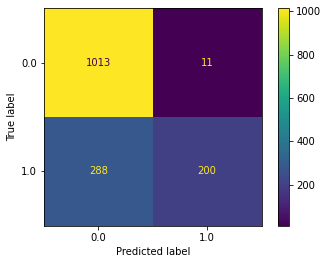

In [1129]:
plot_confusion_matrix(grid_rfc.best_estimator_, X_train, y_train,values_format = '')

We see that the False Negatives are on higher side, hence for future work we can consider analyzing in depth the reason and try out penalizing more for such FNs. For now, since the results are decent, we proceed with the Random Forest Model.

Having finalized the model, we will now extract the Important Features from the trained model.

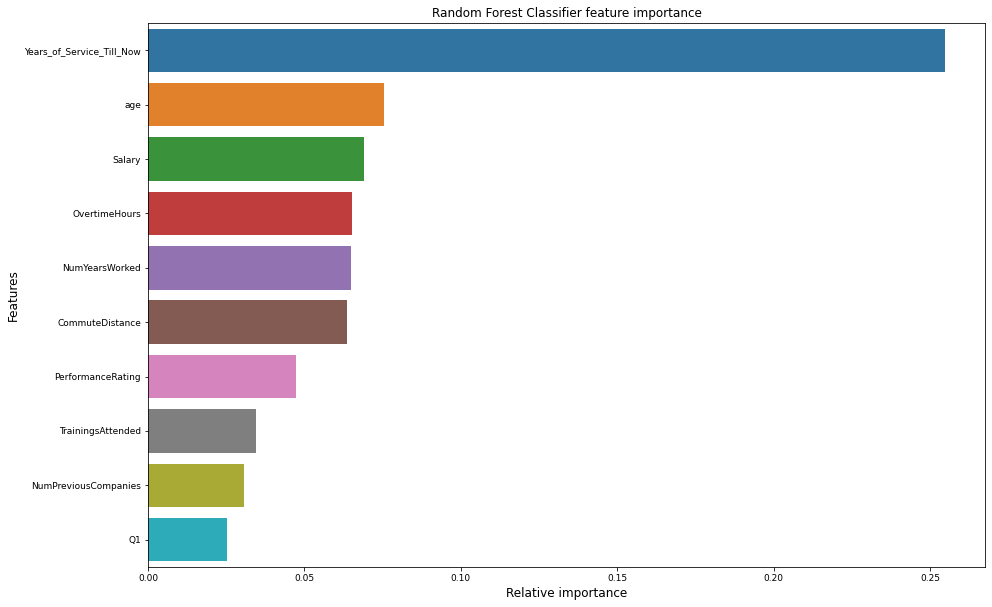

In [1137]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nrows =  1
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = 1, sharex="all", figsize=(15,10))

names_classifiers = [("Random Forest Classifier",grid_rfc.best_estimator_)]
nclassifier = 0
for row in range(nrows):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:10]
        g = sns.barplot(y=X_train.columns[indices][:10],x = classifier.feature_importances_[indices][:10] , orient='h')
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        top_features = X_train.columns[indices][:10]

In [1008]:
# Save the Modle to file in the current working directory
Pkl_Filename = "Attrition_Classifier.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(grid_rfc.best_estimator_, file)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# Conclusion

Through the work, we framed a Data Science model to predict the attrition in employees. We started with aggregating the performance of employees, analyzing surveys and then imputed the missing values for Performance Rating, Marital Status, Number of Previous Companies and Degree Field using respective patterns for the features.

The Random Forests model also helped us find the important factors responsible for attrition in employees. 

The top Important Features being -  <b><i> Years of Service Till Now , Age, Salary, Overtime Hours, Number of Years Worked, Commute Distance, Performance Rating, Trainings Attended, Number of Previous Companies, Q1 </i></b>

Through our Exploratory Data Analysis and using Predictive Modeling we can summarize that:

- Employees with more than 20 Years of experience tend to leave more as compared to others
- Attrition is more in employees with age > 45
- With Salaries > ~75000, the attrition is more against employees with salaries less than ~75000
- Higher number of employees have left the company who have attended 1-2 Trainings and have worked for 2-3 companies previously
- Employees who commute more than 12 Miles have shown higher attrition rates.
- Employees with   ratings in between 3-3.5 tend to leave the organisation more as compared to others
- Employees with Masters and Bachelors degrees tend to leave more against other degrees
- Employees in Job Levels 1,2 and 3 leave quite often relative to Levels 4 and 5
- Employees who have responded  "How satisfied are you with your manager?" with "Somewhat Satisfied" have higher chances of leaving the company
- Employees who responded to "How would you rate you work/life balance?" as Excellent showed lesser chance of leave the company

Strategies such as rewards, conducting trainings for senior employees, understanding compensation (are their salaries competitive enough), giving commute allowance and frequent asking respective Managers to interact with employees to improve their experience in the organisation.

# Model Execution

For test run, the below snippet can be used for execution. The final model has been exported as a pickel file and has been shared with the code. The pkl file can be saved to a location along with the 3 Files (in same format). 

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
import re
#%%capture
from fancyimpute import KNN
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,recall_score,precision_score,plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

Using TensorFlow backend.


Once the 3 Test Files and the pkl file has been saved, please pass the location to below file import codes. The predictions will be added as a column to the employees file and will be exported as a csv file 'Predictions.csv'

In [2]:
employee_test_df = pd.read_excel('/Users/sagarsahoo/Downloads/slalom_case_study/test/employee.xlsx')
performance_test_df = pd.read_excel('/Users/sagarsahoo/Downloads/slalom_case_study/test/performance.xlsx')
survey_test_df = pd.read_excel('/Users/sagarsahoo/Downloads/slalom_case_study/test/survey.xlsx')
Pkl_Filename = "/Users/sagarsahoo/Downloads/slalom_case_study/test/Attrition_Classifier.pkl"


employee_test_df = employee_test_df[employee_test_df['EmploymentEndReason']!='Fired']
performance_agg_test_df = performance_test_df.groupby('EmployeeId').agg({'PerformanceRating':'mean'}).reset_index()
survey_test_df.replace(to_replace=['Excellent', 'Fair', 'Good', 'Neither Satisfied nor Unsatisfied', 'Poor', 'Somewhat Satisfied','Somewhat Unsatisfied', 'Very Poor', 'Very Satisfied', 'Very Unsatisfied'], value=[10,7,8,5,2,6,4,1,9,3],inplace=True)
survey_agg_test_df = survey_test_df.set_index(['EmployeeId','QuestionNum']).unstack()['Response'].reset_index()
survey_agg_test_df.columns=['EmployeeId','Q1','Q2','Q3','Q4']
survey_agg_test_df['EmployeeId'] = survey_agg_test_df['EmployeeId'].apply(str)
survey_agg_test_df['EmployeeId'] = survey_agg_test_df['EmployeeId'].apply(lambda row: re.sub("[^0-9]", "", row))
survey_agg_test_df['EmployeeId'] = survey_agg_test_df['EmployeeId'].apply(int)

intermediate_merge_test_df = pd.merge(employee_test_df,performance_agg_test_df,left_on='EmployeeId', right_on='EmployeeId',how='left')
employee_merged_test_df = pd.merge(intermediate_merge_test_df, survey_agg_test_df,left_on='EmployeeId', right_on='EmployeeId',how='left')
employee_merged_test_df.set_index('EmployeeId', inplace=True)
employee_final_test_df = employee_merged_test_df.copy()

#employee_df['Attrition'] = employee_df
employee_final_test_df.loc[employee_final_test_df['EmploymentEndDate'].isna(), 'Attrition'] = 0
employee_final_test_df.loc[employee_final_test_df['EmploymentEndDate'].notna(), 'Attrition'] = 1
employee_final_test_df.drop(columns=['EmploymentEndDate','EmploymentEndReason'],inplace=True)
employee_final_test_df['age']=pd.to_datetime('now').year - employee_final_test_df['YearOfBirth']
employee_final_test_df['Years_of_Service_Till_Now']=round((((pd.to_datetime('now') - employee_final_test_df['EmploymentStartDate'])/np.timedelta64(1, 'M')))/12,1)
employee_final_test_df.drop(columns=['EmploymentStartDate'],inplace=True)

employee_final_test_df.loc[employee_final_test_df['DegreeCompleted']=='Below College', 'DegreeField'] = 'No Degree'

employee_final_test_df.loc[employee_final_test_df['MaritalStatus'].isna(), 'MaritalStatus'] = 'Married'
employee_final_test_df.loc[employee_final_test_df['PerformanceRating'].isna(), 'PerformanceRating'] = 3

missing_NumPreviousCompanies_test = KNN(k=3).fit_transform(employee_final_test_df[['JobLevel','NumYearsWorked','age','Salary','NumPreviousCompanies']])
employee_final_test_df['NumPreviousCompanies'] = missing_NumPreviousCompanies_test[:,-1].round()

employee_processed_test_df = employee_final_test_df.copy()

X_Prod = employee_processed_test_df[['CommuteDistance', 'DegreeCompleted', 'DegreeField', 'Department',
       'Gender', 'JobLevel', 'MaritalStatus', 'NumPreviousCompanies',
       'NumYearsWorked', 'OvertimeDays', 'OvertimeHours', 'Salary',
       'TrainingsAttended', 'TravelFrequency', 'WeeklyHoursBudgeted',
       'PerformanceRating', 'Q1', 'Q2', 'Q3', 'Q4',
       'age', 'Years_of_Service_Till_Now']]

X_Prod = pd.get_dummies(data=X_Prod, columns=['DegreeCompleted', 'MaritalStatus','DegreeField', 'Department','Gender','TravelFrequency', 'MaritalStatus'])

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_Model = pickle.load(file)

employee_test_df['Prediction'] = Pickled_Model.predict(X_Prod)
#employee_final_test_df['Prediction_Prob'] = Pickled_Model.predict_proba(X_Prod)
employee_test_df['Prediction'].replace(to_replace=[1,0], value=['Yes','No'],inplace=True)


employee_test_df.to_csv('/Users/sagarsahoo/Downloads/slalom_case_study/test/Predictions.csv')

Imputing row 1/1890 with 0 missing, elapsed time: 0.722
Imputing row 101/1890 with 0 missing, elapsed time: 0.724
Imputing row 201/1890 with 0 missing, elapsed time: 0.725
Imputing row 301/1890 with 0 missing, elapsed time: 0.726
Imputing row 401/1890 with 0 missing, elapsed time: 0.727
Imputing row 501/1890 with 0 missing, elapsed time: 0.728
Imputing row 601/1890 with 0 missing, elapsed time: 0.729
Imputing row 701/1890 with 0 missing, elapsed time: 0.731
Imputing row 801/1890 with 0 missing, elapsed time: 0.732
Imputing row 901/1890 with 0 missing, elapsed time: 0.733
Imputing row 1001/1890 with 0 missing, elapsed time: 0.734
Imputing row 1101/1890 with 0 missing, elapsed time: 0.735
Imputing row 1201/1890 with 0 missing, elapsed time: 0.736
Imputing row 1301/1890 with 0 missing, elapsed time: 0.737
Imputing row 1401/1890 with 0 missing, elapsed time: 0.739
Imputing row 1501/1890 with 0 missing, elapsed time: 0.740
Imputing row 1601/1890 with 0 missing, elapsed time: 0.741
Imputing 